In [1]:
import torch

import os.path
import matplotlib.pyplot as plt

from train import main as train
from test import main as test
from plot import read_train_log, train_plot, read_test_log, test_plot, read_test_all_log, test_all_plot

from models.vgg import vgg19
from models.b_cnn import b_cnn

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# 0. Setting Hyper-parameters
The hyper-parameter can be further tuned to achieve higher performance.

In [2]:
class ARGS:
    def __init__(self):
        self.num_epoch = 3
        self.batch_size = 64
        self.gpu = True
        self.resume = False
        self.path = 'results'
    
    def set_model(self, model, learning_rate):
        self.model = model
        self.learning_rate = learning_rate
        return self
    
    def set_dataset(self, dataset):
        self.dataset = dataset
        return self

args = ARGS()

# 1. Training

Because of long log messages, the result plots are only displayed.  
For training, you can use the commented code part.

In [3]:
def show_train_plot(args):
    plot_path = os.path.join(args.path, 'plots')
    os.makedirs(os.path.join(args.path, 'plots'), exist_ok=True)

    train_log_path = os.path.join(args.path, f'logs/{args.model}_{args.dataset}_train.log')
    if not os.path.isfile(train_log_path):
        print(f'No train log for {args.model} on {args.dataset}!!!')
        return
    train_log_file = open(train_log_path)
    losses, accuracies = read_train_log(train_log_file)
    train_plot(losses['train'], losses['test'], 'loss', f'{args.model}_{args.dataset}', plot_path)
    train_plot(accuracies['train'], accuracies['test'], 'accuracy', f'{args.model}_{args.dataset}', plot_path)

## 1-1. VGG19 on CIFAR100

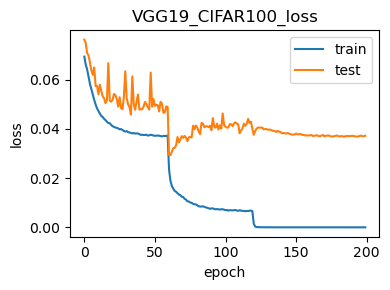

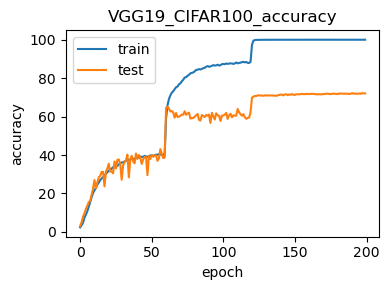

In [4]:
args = args.set_model('VGG19', 0.1).set_dataset('CIFAR100')
# train(args)
show_train_plot(args)

## 1-2. VGG19 on CUB200

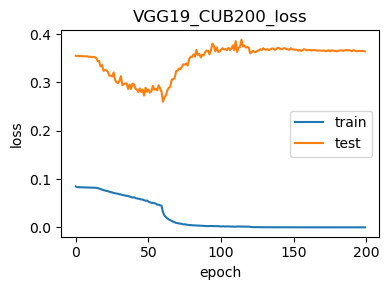

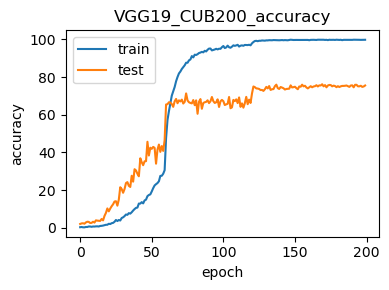

In [5]:
args = args.set_model('VGG19', 0.1).set_dataset('CUB200')
# train(args)
show_train_plot(args)

## 1-3. B-CNN on CIFAR100

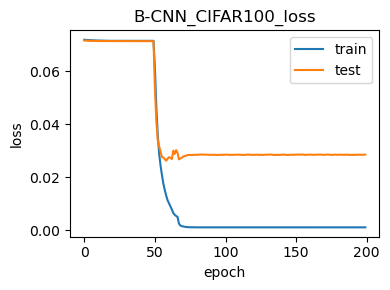

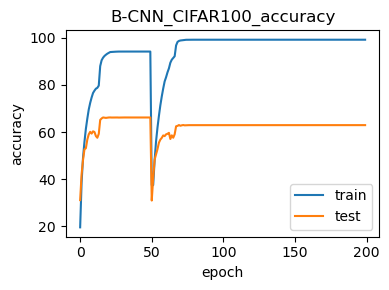

In [6]:
args = args.set_model('B-CNN', 1.0).set_dataset('CIFAR100')
# train(args)
show_train_plot(args)

## 1-4. B-CNN on CUB200

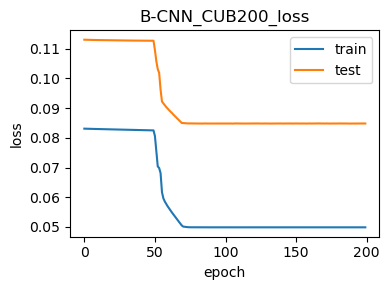

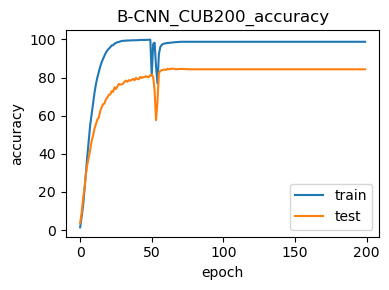

In [7]:
args = args.set_model('B-CNN', 1.0).set_dataset('CUB200')
# train(args)
show_train_plot(args)

# 2. Analysis: Fine vs. Coarse

In [8]:
def hist_plot(model, title, scale):
    params = []
    for name, param in model.named_parameters():
        if 'feature_extractor' in name:
            params += param.data.flatten().tolist()
    
    plt.figure(figsize=(4, 3))
    plt.hist(params, bins=50, range=(-scale, scale))
    plt.title(title)
    plt.xlabel('value')
    plt.ylabel('count')
    plt.show()

    params = torch.tensor(params)
    print(params.mean(), params.std())

def heatmap_plot(model, title):
    params = {}
    for name, param in model.named_parameters():
        if 'feature_extractor' in name:
            idx = name.split('.')[1]
            param_ = param.data.view(param.data.shape[0], -1)
            params[idx] = torch.cat((params[idx], param_), dim=1) if idx in params else param_

    values = []
    for param in params.values():
        values_per_pos = []
        scale = param.shape[0] // 8
        for i in range(8):
            values_per_pos.append(param[i * scale : (i + 1) * scale].abs().mean().item())
        values.append(values_per_pos)
    
    scale = len(values) // 4
    values = [[sum(values[z][j] for z in range(i * scale, (i + 1) * scale)) / scale for j in range(8)] for i in range(4)]
    
    plt.figure(figsize=(4, 3))
    plt.imshow(values)
    plt.title(title)
    plt.xlabel('channel position')
    plt.ylabel('layer position')
    plt.xticks(range(8), list(range(8)))
    plt.yticks(range(4), list(range(4)))
    plt.colorbar()
    plt.show()

## 2-1. Weight Distribution Analysis

- Fine-grained dataset (e.g., CUB200) shows high variance
- Fine-grained classifier (e.g., B-CNN) shows high variance

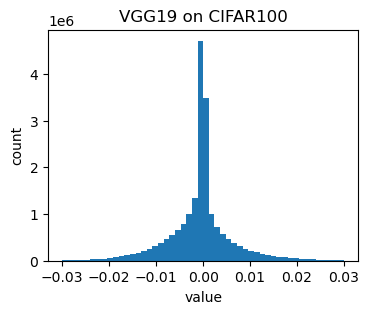

tensor(-0.0005) tensor(0.0078)


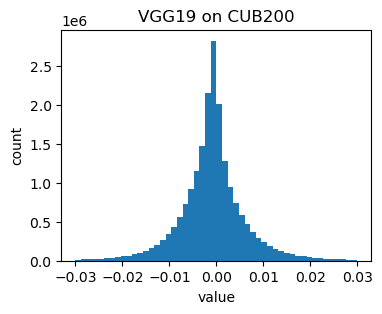

tensor(-0.0008) tensor(0.0118)


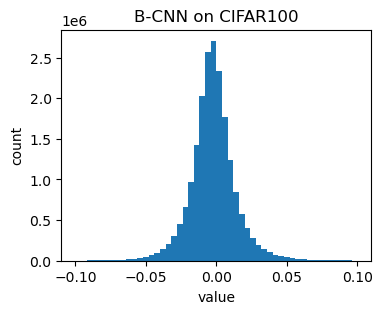

tensor(-0.0024) tensor(0.0174)


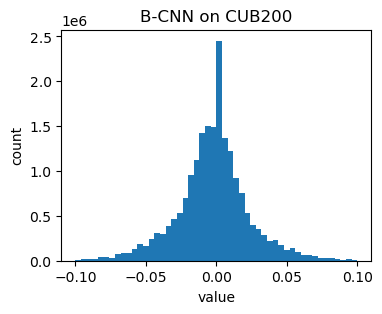

tensor(-0.0025) tensor(0.0273)


In [9]:
model_dict = {'VGG19': vgg19, 'B-CNN': b_cnn}
in_size_dict = {'CIFAR100': 32, 'CUB200': 448}
num_class_dict = {'CIFAR100': 100, 'CUB200': 200}
scale_dict = {'VGG19': 0.03, 'B-CNN': 0.1}

for model in ['VGG19', 'B-CNN']:
    for dataset in ['CIFAR100', 'CUB200']:
        net = model_dict[model](args, in_size_dict[dataset], num_class_dict[dataset]).model
        state_dict = torch.load(f'results/weights/{model}_{dataset}.pth')['best_state_dict']
        net.load_state_dict(state_dict)

        title = f'{model} on {dataset}'
        hist_plot(net, title, scale_dict[model])

## 2-2. Weight Heatmap Analysis

- Weights of fine-grained classifier shows low value in deeper layer
- Weights of fine-grained classifier shows low value in middle channel

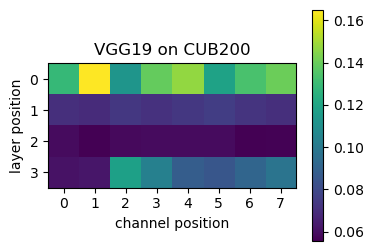

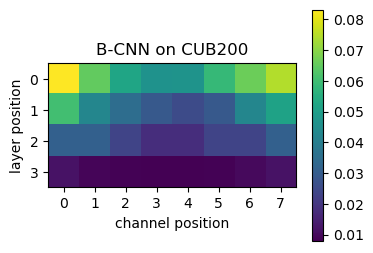

In [10]:
model_dict = {'VGG19': vgg19, 'B-CNN': b_cnn}
in_size = 448
num_class = 200

for model in ['VGG19', 'B-CNN']:
    net = model_dict[model](args, in_size_dict[dataset], num_class_dict[dataset]).model
    state_dict = torch.load(f'results/weights/{model}_CUB200.pth')['best_state_dict']
    net.load_state_dict(state_dict)

    title = f'{model} on CUB200'
    heatmap_plot(net, title)

# 3. Quantizer Performance Comparison

Because of long log messages, the result plots are only displayed.  
For training, you can use the commented code part.

## 3-1. Overall Comparison

- PosTeQ performs better than MinTeQ on fine-grained classifier while performs worse on coarse-grained classifier
- PosTeQ performs much better on fine-grained classifier than on coarse-grained classifier

In [11]:
def show_test_plot(args):
    plot_path = os.path.join(args.path, 'plots')
    os.makedirs(os.path.join(args.path, 'plots'), exist_ok=True)

    test_log_path = os.path.join(args.path, f'logs/{args.model}_{args.dataset}_test.log')
    if not os.path.isfile(test_log_path):
        print(f'No test log for {args.model} on {args.dataset}!!!')
        return
    test_log_file = open(test_log_path)
    base_accuracy, quantizers, precisions, accuracies = read_test_log(test_log_file)
    test_plot(base_accuracy, quantizers, precisions, accuracies, f'{args.model}_{args.dataset}', plot_path)

### 3-1-1. VGG19 on CIFAR100

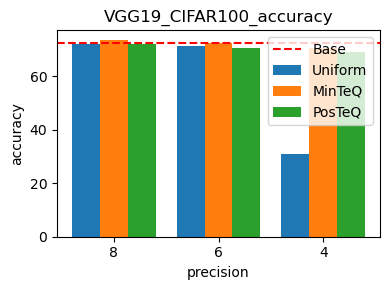

In [12]:
args = args.set_model('VGG19', 0.1).set_dataset('CIFAR100')
# test(args)
show_test_plot(args)

### 3-1-2. VGG19 on CUB200

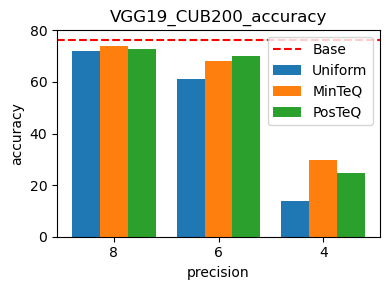

In [13]:
args = args.set_model('VGG19', 0.1).set_dataset('CUB200')
# test(args)
show_test_plot(args)

### 3-1-3. B-CNN on CIFAR100

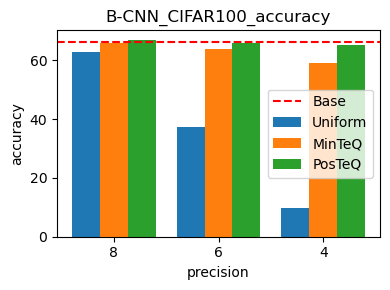

In [14]:
args = args.set_model('B-CNN', 1.0).set_dataset('CIFAR100')
# test(args)
show_test_plot(args)

### 3-1-4. B-CNN on CUB200

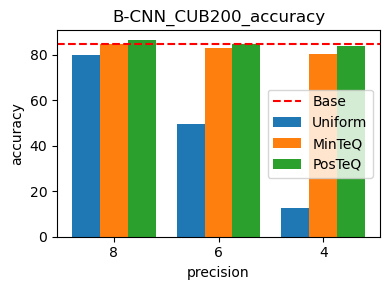

In [15]:
args = args.set_model('B-CNN', 1.0).set_dataset('CUB200')
# test(args)
show_test_plot(args)

## 3-2. Ablation Study

- Using multiple bit-precisions are beneficial (Textual)
- Assigning high-precision to lower values are beneficial (Position-aware)

In [16]:
def show_test_all_plot(args):
    plot_path = os.path.join(args.path, 'plots')
    os.makedirs(os.path.join(args.path, 'plots'), exist_ok=True)

    test_all_log_path = os.path.join(args.path, f'logs/{args.model}_{args.dataset}_test_all.log')
    if not os.path.isfile(test_all_log_path):
        print(f'No test log for {args.model} on {args.dataset}!!!')
        return
    test_all_log_file = open(test_all_log_path)
    base_accuracy, composes, precisions, accuracies_per_quantizer = read_test_all_log(test_all_log_file)
    test_all_plot(base_accuracy, composes, precisions, accuracies_per_quantizer['MinTeQ'], f'{args.model}_{args.dataset}_MinTeQ', plot_path)
    test_all_plot(base_accuracy, composes, precisions, accuracies_per_quantizer['PosTeQ'], f'{args.model}_{args.dataset}_PosTeQ', plot_path)

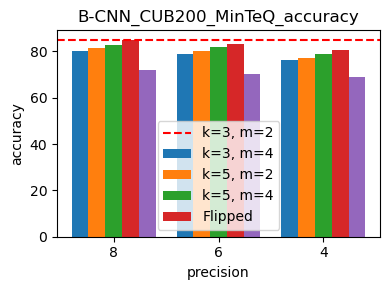

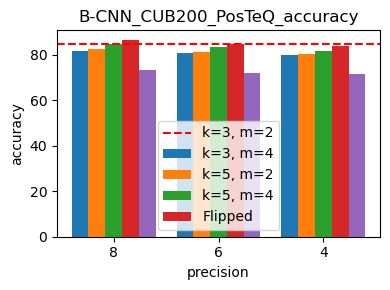

In [17]:
args = args.set_model('B-CNN', 1.0).set_dataset('CUB200')
# test(args)
show_test_all_plot(args)